# The problem 
An ant leaves its anthill in order to forage for food. It moves with the speed of 10cm per second, but it doesn't know where to go, therefore every second it moves randomly 10cm directly north, south, east or west with equal probability.

1. If the food is located on east-west lines 20cm to the north and 20cm to the south, as well as on north-south lines 20cm to the east and 20cm to the west from the anthill, how long will it take the ant to reach it on average?

2. What is the average time the ant will reach food if it is located only on a diagonal line passing through (10cm, 0cm) and (0cm, 10cm) points?

3. Can you write a program that comes up with an estimate of average time to find food for any closed boundary around the anthill? What would be the answer if food is located outside an defined by $((x – 2.5cm) / 30cm )^{2} + ( (y – 2.5cm) / 40cm )^{2} < 1$ in coordinate system where the anthill is located at (x = 0cm, y = 0cm)?



# Random Walk Background
## One Dimension
### Expectation and Variance
Consider the ant is moving along a straight line (e.g. the x axis). At each time step the ant either moves in the positive or negative x direction with equal probability.
Considering just the first timestep $t^{0}$ it is easy to see that the expectation of the position at $t^{1}$ is given by $E(x^{1} = x_{i}) = \sum_{i}^{1} x_i p_i = 0$, where $x_i \in {-1, +1}$ and $p_0 = p_1 = 0.5$. Similarly it can be shown that $var(x^{1}) = 1, \implies \sigma(x^{1}) = 1$.
Now generalising to the nth timestep we have that $E(x^{n}) = \sum_{j=0}^{n} E(x^{j}) = 0$. Using the definition of variance: $var(x) = E(x^{2}) - E(x)^2$ we can see that $var(x^{n}) = n \implies \sigma(x^{n}) = \sqrt{n}$.

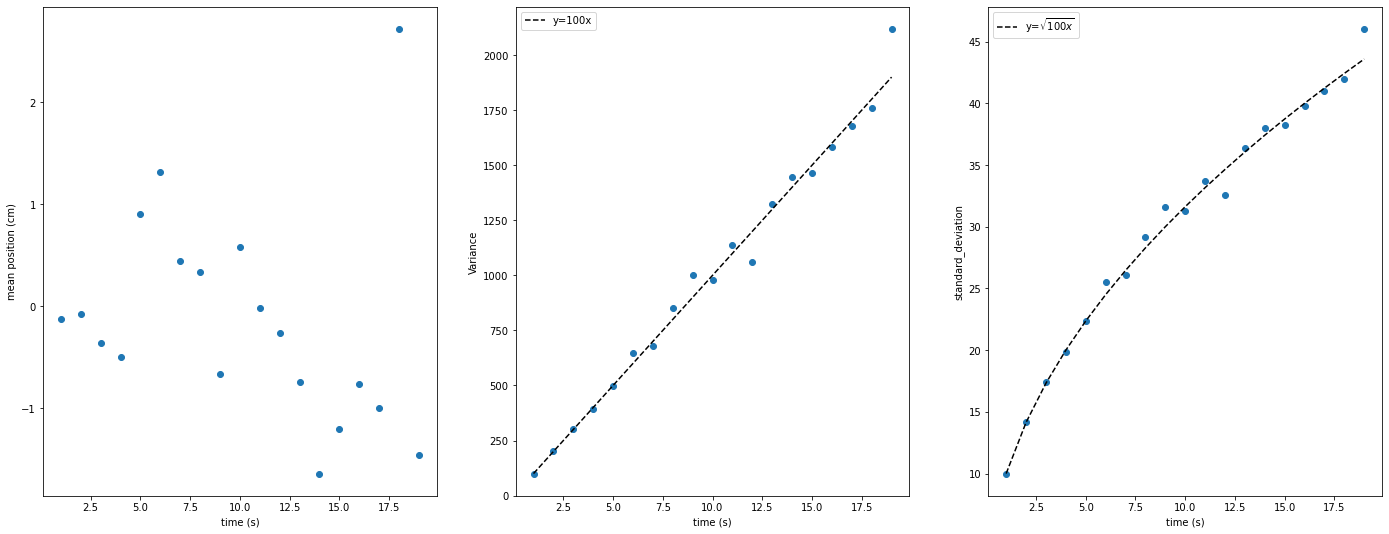

In [96]:
# lets check our calculation with a simple monte carlo simulation
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from math import sqrt

# Let's create a base class that 1d and 2d ants can inherit from
class AntBase(metaclass=ABCMeta):
    def __init__(self):
        self.rng = default_rng()
        self.reset_coords()
    
    @abstractmethod
    def move(self) -> None:
        pass

    @abstractmethod
    def at_food(self) -> bool:
        pass

    @abstractmethod
    def reset_coords(self) -> None:
        pass

    def time_to_food(self) -> int:
        """
        Time how long ant takes to get to food 
        """
        seconds = 0
        while not self.at_food():
            seconds += 1
            self.move()
        self.reset_coords()
        return seconds

# 1d ant inherits from base
class Ant1D(AntBase):
    def move(self) -> None:
        """
        Move the ant one random step +/- 10 cm along x axis 
        """
        self.x += self.rng.choice((-10, +10))

    def at_food(self) -> bool:
        """
        Determine whether ant is at food or not 
        """
        return abs(self.x) >= 20

    def reset_coords(self) -> None:
        """
        Reset ant's position to the origin
        """
        self.x = 0


ant = Ant1D()
num_repeats = 1000
timesteps = range(1, 20)
means = []
variances = []
standard_deviations = []

for t in timesteps:
    positions = []
    for repeat in range(num_repeats):
        for i in range(t):
            ant.move()
        positions.append(ant.x)
        ant.reset_coords()
    mean = sum(positions) / num_repeats
    means.append(mean)
    variance = sum((mean - i) ** 2 for i in positions) / num_repeats
    variances.append(variance)
    standard_deviations.append(sqrt(variance))

fig, ax = plt.subplots(1, 3, figsize=(24, 9))
ax[0].scatter(timesteps, means)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("mean position (cm)")
ax[1].scatter(timesteps, variances)
ax[1].plot(timesteps, [t * 100 for t in timesteps], linestyle="dashed", color="k", label="y=100x")
ax[1].legend()
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("Variance")
ax[2].scatter(timesteps, standard_deviations)
ax[2].plot(timesteps, [10*sqrt(t) for t in timesteps], label=r"y=$\sqrt{100x}$", linestyle="dashed", color="k")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("standard_deviation")
ax[2].legend()
plt.show()

### The 1D problem
Now let's consider the one dimensional analogue to our two dimensional problem, what is the expectated number of timesteps for our ant to reach either +20cm or -20 cm? Clearly for reaching +/- 10cm this always happens on the first timestep. Let's consider the different permutations for timesteps and their associated probabilities. Clearly for n=1 the ant can never reach the food since they move at $10 ms^{-1}$. For the n=2 case we have 2 distinct permutations - moving in the same direction for the first 2 consecutive timesteps so $p(n=2) = 2 * \frac{1}{2^{2}} = \frac{1}{2}$. For the n=3 case we can see that we have zero probability. For the n=4 case we have 4 distinct permutations, moving initially in one direction and then either the opposite direction for the next 3 steps, or the opposite direction and then the initial direction for 2 consecutive steps. $p(n=4) = 4 * \frac{1}{2^{4}} = \frac{1}{4}$. We can rewrite this as $p(n=4) = \frac{1}{2} * p(n=2)$. Again for the n=5 case we can see that we have zero probability, in fact this is true for all odd n. For n=6 we can again see that there are 2 distinct branches for the first 2 moves (moving in one direction and then returning to the origin), before we arrive at the n=4 scenario: $p(n=6) = \frac{1}{2} * p(n=4) = \frac{1}{8}$. For even n we can generalise to $p(n) = \frac{1}{2^{\frac{n}{2}}}$. We can now write the expectation of n as $ E = \sum_{i=1}^{\infty} \frac{2i}{2^{i}} = 2\sum_{i=1}^{\infty} \frac{i}{2^{i}}$. Let's first check to see if this series converges using the ratio test: $|\lim_{n \to \infty} \frac{(n+1) \cdot 2^{n-1}}{n \cdot 2^{n}}| = |\lim_{n \to \infty} \frac{n+1}{2n}| = |\lim_{n \to \infty} \frac{1}{2} + \frac{1}{2n}| = \frac{1}{2} < 1$, therefore the series converges. To compute the sum, first explicitly write out a few terms: $S = \sum_{i=1}^{\infty} \frac{i}{2^{i}} = \frac{1}{2^1} + \frac{2}{2^2} +\frac{3}{2^3}+ \frac{4}{2^4} + ...$ $S = \sum_{i=1}^{\infty} \frac{1+0}{2^1} \frac{1+1}{2^2} + \frac{1+2}{2^3} + \frac{1+3}{2^4} = \sum_{i=1}^{\infty} \frac{1}{2^{i}} + \sum_{i=1}^{\infty} \frac{i}{2^{n+1}} = \sum_{i=1}^{\infty} \frac{1}{2^{i}} + \frac{1}{2} S$. We can simplify this to give an expression for S: $S = 2 \sum_{i=1}^{\infty} \frac{1}{2^{i}}$. Now we note the summation expression on the RHS is a simple geometric progression and totals 1. Hence we are left with $S = 2 \frac{\frac{1}{2}}{1-\frac{1}{2}} = 2 \implies E = 2S = 4$.

In [67]:
from numpy.random import default_rng
import numpy as np

rng = default_rng()
num_repeats = int(1e5)
trials = np.zeros(num_repeats)

for trial in range(num_repeats):
    pos = 0
    steps = 0
    while abs(pos) < 2:
        steps += 1
        pos += rng.choice((-1, 1))
    trials[trial] = steps

mean = np.mean(trials)
variance = np.sum((trials - mean) ** 2) / num_repeats
standard_deviation = np.sqrt(variance)

print(f"{mean=}\n{variance=}\n{standard_deviation=}")

mean=3.99958
variance=7.957799823599998
standard_deviation=2.820957253061449


In [69]:
np.sum(trials == 4)/num_repeats

0.25037

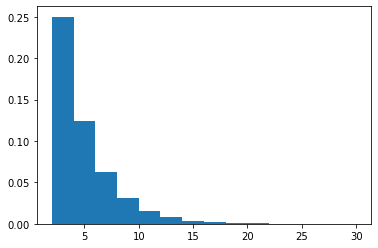

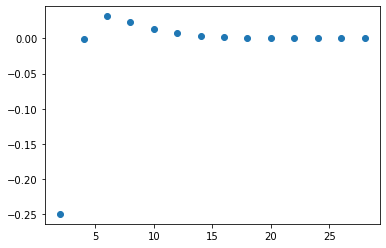

In [61]:
bins = np.arange(2, 32, 2)
hist, bins, patches = plt.hist(trials, density=True, bins=bins)
plt.show()
errors = hist - (1/(2**(bins[:-1] -1)))
plt.scatter(bins[:-1], errors)
plt.show()

In [66]:
np.sum(hist * bins[:-1])

2.005660339620377

In [63]:
np.sum(0.5 * (bins[:-1] + bins[1:]) * hist)

2.505660339620377

In [58]:
hist

array([2.50165010e-01, 1.23777427e-01, 6.28787727e-02, 3.13218793e-02,
       1.57559454e-02, 8.09548573e-03, 3.91023461e-03, 2.09012541e-03,
       1.06506390e-03, 5.05030302e-04, 2.40014401e-04, 1.05006300e-04,
       5.50033002e-05, 3.50021001e-05])

In [27]:
from numpy.random import default_rng
import matplotlib.pyplot as plt


class Ant:
    def __init__(self) -> None:
        self.x: int = 0
        self.y: int = 0
        self.rng = default_rng()

    def move(self) -> None:
        """
        Move ant  
        """
        move = self.rng.choice(["N", "E", "S", "W"])
        if move == "N":
            self.y += 10
        if move == "S":
            self.y -= 10
        if move == "E":
            self.x += 10
        if move == "W":
            self.x -= 10

    def at_food(self) -> bool:
        return (abs(self.x) >= 20) or (abs(self.y) >= 20)

    def time_to_food(self) -> int:
        seconds = 0
        while not self.at_food():
            seconds += 1
            self.move()
        self.reset_coords()
        return seconds

    def reset_coords(self) -> None:
        self.x = 0
        self.y = 0

    def plot_walk(self) -> None:
        points = [(0, 0)]
        seconds = 0
        while not self.at_food():
            seconds += 1
            self.move()
            points.append((self.x, self.y))
        plt.plot([p[0] for p in points], [p[1] for p in points])
        plt.suptitle(f"{seconds=}")
        self.reset_coords()

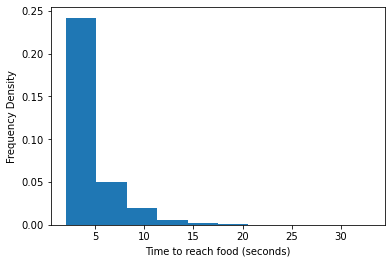

In [28]:
import numpy as np

ant = Ant()
num_repeats = int(1e5)

times = np.array([ant.time_to_food() for _ in range(num_repeats)])
plt.hist(times, density=True)
plt.xlabel("Time to reach food (seconds)")
plt.ylabel("Frequency Density")
plt.show()

In [29]:
mean = np.mean(times)
variance = np.sum((times - mean) ** 2) / num_repeats
stdev = np.sqrt(variance)

print(f"{mean=:.3f}\n{variance=:.3f}\n{stdev=:.3f}")

mean=4.498
variance=8.247
stdev=2.872
